# Additional analyses for EPA Project
This notebook manipulates the full df of valid gages for additional HMF metrics

In [8]:
#Python3.10
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import calendar
from importlib import reload
import mapclassify as mc

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib.ticker import ScalarFormatter
from shapely.geometry import Point

# USGS Data retreival tool
from datetime import datetime, timedelta
from dataretrieval import nwis, utils, codes

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func_ko as fn
reload(cl)
reload(fn)

<module 'Src.func_ko' from 'C:\\Users\\kondris\\Documents\\GitHub\\HighMagFlows_EPA_Project\\Src\\func_ko.py'>

## Calculate percent of HMF flows to total flows over record

### Upload valid gages

In [19]:
# All gages - National metrics dfs
data_paths = {
    '30_90': 'Prelim_Data/National_Metrics/National_Metrics_30_90.xlsx',
    '50_90': 'Prelim_Data/National_Metrics/National_Metrics_50_90.xlsx',
    '30_95': 'Prelim_Data/National_Metrics/National_Metrics_30_95.xlsx',
    '50_95': 'Prelim_Data/National_Metrics/National_Metrics_50_95.xlsx'    
}

dfs_metrics = {key: pd.read_excel(path, sheet_name='site_metrics') for key, path in data_paths.items()}

In [26]:
# Converts site_no to strings
date_ranges = ['30', '50']
percentiles = ['90', '95']
for date_range in date_ranges:
    for percentile in percentiles: 
        # Assuming df is your DataFrame and 'column_name' is the name of the column with numbers
        dfs_metrics[f'{date_range}_{percentile}']['site_no'] = dfs_metrics[f'{date_range}_{percentile}']['site_no'].astype(str)  # Convert numbers to strings

        # Add leading '0' to numbers with 7 digits
        dfs_metrics[f'{date_range}_{percentile}']['site_no'] = dfs_metrics[f'{date_range}_{percentile}']['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)

In [30]:
# Valid gages - National metrics dfs
dfs_valid = {}
for date_range in date_ranges:
    for percentile in percentiles: 
        dfs_valid[f'{date_range}_{percentile}'] = dfs_metrics[f'{date_range}_{percentile}'][dfs_metrics[f'{date_range}_{percentile}']['valid'] == True]

In [2]:
# # Dataset upload
# data_paths = {
#     '30_90': 'Prelim_Data/National_Metrics/Station_names/National_Metrics_30_90.xlsx',
#     '50_90': 'Prelim_Data/National_Metrics/Station_names/National_Metrics_50_90.xlsx',
#     '30_95': 'Prelim_Data/National_Metrics/Station_names/National_Metrics_30_95.xlsx',
#     '50_95': 'Prelim_Data/National_Metrics/Station_names/National_Metrics_50_95.xlsx'    
# }

# #dfs_metrics = {key: pd.read_excel(path, sheet_name='site_metrics') for key, path in data_paths.items()}
# dfs_valid = {key: pd.read_excel(path) for key, path in data_paths.items()}

In [31]:
dfs_valid['30_90']['site_no']

1       02342500
2       02361000
4       02363000
6       02369800
7       02371500
          ...   
7894    09211200
7897    09217000
7901    09223000
7902    09224700
7912    13018300
Name: site_no, Length: 4242, dtype: object

In [32]:
site_nos = {}
date_ranges = ['30', '50']
percentiles = ['90', '95']
for date_range in date_ranges:
    for percentile in percentiles:
        df = dfs_valid[f'{date_range}_{percentile}']
        site_nos[f'{date_range}_{percentile}'] = df['site_no'].unique().tolist()
print(len(site_nos['30_90']))
print(len(site_nos['50_90']))

4242
3314


In [151]:
date_range = '30'
percentile = '95'
site_no = '06764880'
data_range = int(date_range)
quantile = int(percentile)/100

def get_df_hmf(site_no, data_range, quantile):
    df = nwis.get_record(sites=site_no, service=fn.SERVICE, parameterCD=[fn.PARAM_CODE, fn.TIDAL_CODE], start=fn.DEFAULT_START, end=fn.DEFAULT_END)
    if df.empty:
        #natl_blacklist.append(row['site_no'])
        print(f'IGNORED: No data for site {row["site_no"]}')
        continue
    if '00060_radar sensor_Mean' in df.columns and '00060_Mean' not in df.columns:
            df.rename(columns={'00060_radar sensor_Mean': '00060_Mean'}, inplace=True)
    df = fn.merge_tidal(df)
    df = df.reset_index()
    df_copy = df.copy()
    date_threshold = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
    df_copy = df_copy[df_copy['datetime'].dt.date >= date_threshold]
    threshold = fn.calc_threshold(df_copy, quantile)
    df_copy = df_copy.rename(columns={'00060_Mean': 'flow_cfs'})
    df_copy['hmf_cfs'] = [(flow - threshold) if flow > threshold else 0 for flow in df_copy['flow_cfs']]
    return df_copy

def add_wy(df):
    df['month'] = df['datetime'].dt.strftime('%m') # create month column
    df['year'] = df['datetime'].dt.strftime('%Y') # create year column 
    df['WY'] = np.where((df['month'] == '10') | (df['month'] == '11') | (df['month'] == '12'), df['year'].astype(int) + 1, df['year'].astype(int)) # create WY column where the WY resets in Oct
    df['WY'] = df['WY'].values.astype(str)
    df['DOY'] = df['datetime'].dt.dayofyear # create column with DOY
    df['DOHY'] = [d - 273 if d >= 274 else d + 91 for d in df['DOY']]
    df['datetime'] = df['datetime'].dt.date # reset index to date only (no time)
    return df

def plot_full_timeseries(df):
    df_thres = pd.DataFrame(df['flow_cfs'])
    threshold = df_thres.quantile(q=quantile, axis=0).iloc[0]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
    ax.plot(df['datetime'], df['flow_cfs'], label=f'Observed Streamflow')
    ax.axhline(y = threshold, linestyle='--', label=f'Record Threshold (p90)', color='C1')
    ax.plot(df['datetime'], df['hmf_cfs']+threshold, label=f'HMF')
    #ax.fill_between(hmf_series_cont['datetime'], y1=threshold, y2=df_copy['hmf_cfs']+threshold, color='C2', label='HMF')
    
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Discharge (cfs)', fontsize=14)
    ax.set_title(f'HMF Above Record 90th Percentile (USGS ID: {site_no})', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.set_ylim([0, max(df['flow_cfs'])+5000])
    #ax.set_ylim([0, 100000])
    
    plt.legend(loc=1, fontsize=14)
    plt.grid()

    file_name = f'Saved_Visuals/streamflow_timeseries/full_record_{date_range}_{percentile}_{site_no}.png'
    plt.savefig(file_name, bbox_inches="tight")

    plt.show()
    return

SyntaxError: 'continue' not properly in loop (3414627314.py, line 12)

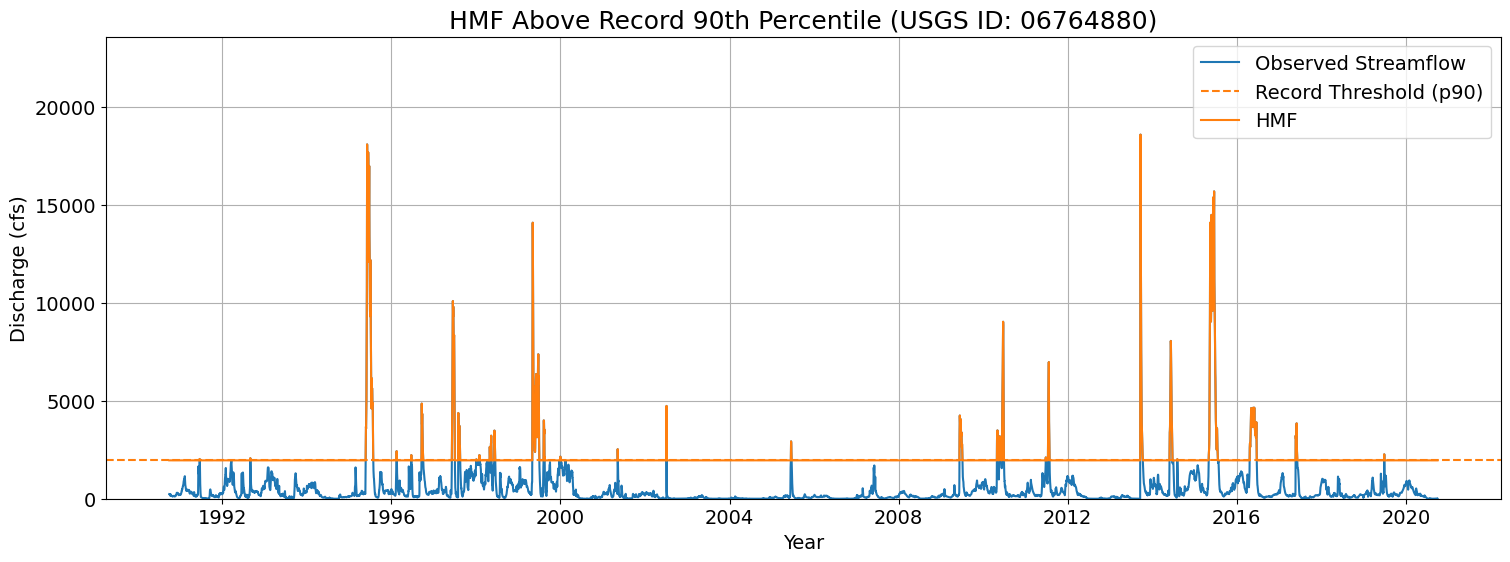

In [152]:
df_hmf = get_df_hmf(site_no, data_range, quantile)
df_hmf_wy = add_wy(df_hmf)
plot_full_timeseries(df_hmf_wy)

In [12]:
cfs_to_km3 = 60 * 60 * 24 / 43560 / 1e6 * 1.233489
daily_sum = sum(df_hmf_wy['flow_cfs']) * cfs_to_km3
hmf_sum = sum(df_hmf_wy['hmf_cfs']) * cfs_to_km3
pct_hmf = round(hmf_sum/daily_sum*100, 1)
pct_hmf

29.0

In [143]:
min_index = merged_df['pct_hmf'].idxmin()
min_row = merged_df.loc[min_index]
min_row

site_no                                 11313405
analyze_start                1990-11-13 00:00:00
analyze_end                  2020-09-30 00:00:00
analyze_range                                 30
quantile                                     0.9
valid                                       True
missing_data%                              7.338
threshold                                  247.6
hmf_years                                     22
annual_hmf                              0.300081
six_mo_hmf                              0.231559
three_mo_hmf                            0.098031
annual_duration                        46.181818
event_duration                         21.918153
event_hmf                                0.17831
inter_annual%                             73.333
intra_annual                            3.454545
timing                                180.590909
jan_hmf                                  0.18106
feb_hmf                                 0.195885
mar_hmf             

In [140]:
hmf_pct_dict['30_95']['pct_hmf'].describe()

count    4211.000000
mean       18.399383
std        16.491333
min        -9.500000
25%         7.900000
50%        13.300000
75%        22.650000
max       100.000000
Name: pct_hmf, dtype: float64

In [117]:
exclude_sites = ['02466030', '022907647', '023177483', '11058837', '94196781', 
                 '10965852', '422026250', '423205010', '208111310', '208521324', 
                 '208732534', '208732885', '208758850', '209741955', '210166029', 
                 '214269560', '344894205', '345577330']
site_no = '02466030'
nwis.get_record(sites=site_no, service=fn.SERVICE, parameterCD=[fn.PARAM_CODE, fn.TIDAL_CODE], start=fn.DEFAULT_START, end=fn.DEFAULT_END)
#get_df_hmf(site_no, data_range, quantile)

,site_no
datetime,


In [146]:
date_ranges = ['30', '50']
percentiles = ['90', '95']
hmf_pct_dict = {}

for date_range in date_ranges:
    for percentile in percentiles:

        data_range = int(date_range)
        quantile = int(percentile) / 100
        
        pct_hmf_list = []
        site_no_list = []
        
        for site_no in site_nos[f'{date_range}_{percentile}']:
            
            df = nwis.get_record(sites=site_no, service=fn.SERVICE, parameterCD=[fn.PARAM_CODE, fn.TIDAL_CODE], start=fn.DEFAULT_START, end=fn.DEFAULT_END)
            df = df.reset_index()
            #print(site_no)
            
            if df.empty:
                #print(f'IGNORED: No data for site {site_no}')
                # Append NaN for the pct_hmf and the site_no
                pct_hmf_list.append(np.nan)
                site_no_list.append(site_no)
                continue
                
            if '00060_radar sensor_Mean' in df.columns and '00060_Mean' not in df.columns:
                df.rename(columns={'00060_radar sensor_Mean': '00060_Mean'}, inplace=True)
                
            df = fn.merge_tidal(df)
            
            df_copy = df.copy()
            date_threshold = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
            df_copy = df_copy[df_copy['datetime'].dt.date >= date_threshold]
            
            column = '00060_2_Mean' if site_no == '01118500' else '00060_Mean'
            df_thres = pd.DataFrame(df[column])
            threshold = df_thres.quantile(q=quantile, axis=0).iloc[0]
            
            df_copy = df_copy.rename(columns={column: 'flow_cfs'})
            df_copy['hmf_cfs'] = [(flow - threshold) if flow > threshold else 0 for flow in df_copy['flow_cfs']]
            
            df_hmf_wy = add_wy(df_copy)
                
            daily_sum = sum(df_hmf_wy['flow_cfs']) * cfs_to_km3
            hmf_sum = sum(df_hmf_wy['hmf_cfs']) * cfs_to_km3
            pct_hmf = round(hmf_sum / daily_sum * 100, 1)
            
            # Append the calculated pct_hmf and site_no
            pct_hmf_list.append(pct_hmf)
            site_no_list.append(site_no)
        
        # Create a DataFrame from the lists
        df_hmf_pct = pd.DataFrame({
            'site_no': site_no_list,
            'pct_hmf': pct_hmf_list
        })
        
        hmf_pct_dict[f'{date_range}_{percentile}'] = df_hmf_pct

In [54]:
site_no = '02466030'
nwis.get_record(sites=site_no, service=fn.SERVICE, parameterCD=[fn.PARAM_CODE, fn.TIDAL_CODE], start=fn.DEFAULT_START, end=fn.DEFAULT_END)
#get_df_hmf(site_no, data_range, quantile)

,site_no
datetime,


In [164]:
dfs_valid_merge = {}
for date_range in date_ranges:
    for percentile in percentiles:
        df1 = dfs_valid[f'{date_range}_{percentile}']
        df2 = hmf_pct_dict[f'{date_range}_{percentile}']
        dfs_valid_merge[f'{date_range}_{percentile}'] = pd.merge(df1, df2, on='site_no', how='inner')

In [198]:
date_ranges = ['30', '50']
percentiles = ['90', '95']
for date_range in date_ranges:
    for percentile in percentiles:
        df = dfs_valid_merge[f'{date_range}_{percentile}']
        dfs_valid_merge[f'{date_range}_{percentile}'] = df.drop(df[df['site_no'] == '11313405'].index)
        dfs_valid_merge[f'{date_range}_{percentile}'] = df[df['pct_hmf'].notna()]
        dfs_valid_merge[f'{date_range}_{percentile}'].to_excel(f'Prelim_Data/National_Metrics/National_Metrics_update_{date_range}_{percentile}.xlsx', index=False)

In [181]:
#dfs_valid_merge['30_90'].sort_values(by='pct_hmf')

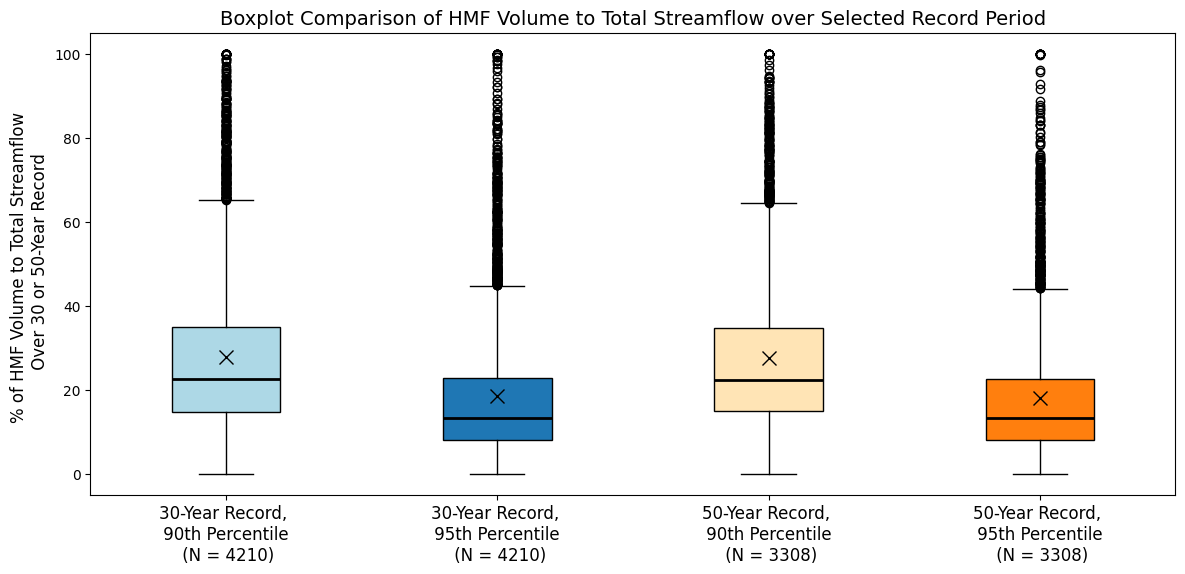

In [203]:
# date_range = '30'
# percentile = '90'
# df = dfs_valid_merge[f'{date_range}_{percentile}']

fig, ax = plt.subplots(figsize=(14, 6))

# Create a boxplot
ax.boxplot(dfs_valid_merge['30_90']['pct_hmf'], positions=[1],
                 patch_artist=True,       # Allow coloring the box
                 showmeans=True,          # Show the mean
                 widths=0.4,              # Adjust width of the box
                 boxprops=dict(facecolor='lightblue', color='black'),  # Box color
                 medianprops=dict(color='black', linewidth=2),          # Median line color
                 meanprops=dict(marker='x', markeredgecolor='black', markerfacecolor='green', markersize=10)  # Mean marker style
                )

ax.boxplot(dfs_valid_merge['30_95']['pct_hmf'], positions=[2],
                 patch_artist=True,       # Allow coloring the box
                 showmeans=True,          # Show the mean
                 widths=0.4,              # Adjust width of the box
                 boxprops=dict(facecolor='C0', color='black'),  # Box color
                 medianprops=dict(color='black', linewidth=2),          # Median line color
                 meanprops=dict(marker='x', markeredgecolor='black', markerfacecolor='green', markersize=10)  # Mean marker style
                )

ax.boxplot(dfs_valid_merge['50_90']['pct_hmf'], positions=[3],
                 patch_artist=True,       # Allow coloring the box
                 showmeans=True,          # Show the mean
                 widths=0.4,              # Adjust width of the box
                 boxprops=dict(facecolor='moccasin', color='black'),  # Box color
                 medianprops=dict(color='black', linewidth=2),          # Median line color
                 meanprops=dict(marker='x', markeredgecolor='black', markerfacecolor='green', markersize=10)  # Mean marker style
                )

ax.boxplot(dfs_valid_merge['50_95']['pct_hmf'], positions=[4],
                 patch_artist=True,       # Allow coloring the box
                 showmeans=True,          # Show the mean
                 widths=0.4,              # Adjust width of the box
                 boxprops=dict(facecolor='C1', color='black'),  # Box color
                 medianprops=dict(color='black', linewidth=2),          # Median line color
                 meanprops=dict(marker='x', markeredgecolor='black', markerfacecolor='green', markersize=10)  # Mean marker style
                )

# Set the title and y-axis label
plt.title('Boxplot Comparison of HMF Volume to Total Streamflow over Selected Record Period', fontsize=14)
plt.ylabel('% of HMF Volume to Total Streamflow \n Over 30 or 50-Year Record', fontsize=12)
ax.set_xticklabels([f"30-Year Record, \n 90th Percentile \n (N = {len(dfs_valid_merge['30_90']['pct_hmf'])})",
                   f"30-Year Record, \n 95th Percentile \n (N = {len(dfs_valid_merge['30_95']['pct_hmf'])})",
                   f"50-Year Record, \n 90th Percentile \n (N = {len(dfs_valid_merge['50_90']['pct_hmf'])})",
                   f"50-Year Record, \n 95th Percentile \n (N = {len(dfs_valid_merge['50_95']['pct_hmf'])})"
                   ], fontsize=12)

plt.savefig(f'Saved_Visuals/HMF_metrics/boxplots/boxplots_hmf%_compare_all_gages.png', bbox_inches='tight')

# Display the plot
plt.show()

In [186]:
for date_range in date_ranges:
    for percentile in percentiles:
        df = dfs_valid_merge[f'{date_range}_{percentile}']
        print(f'Date Range: {date_range}, Percentile: {percentile}')
        print(df['pct_hmf'].describe())

Date Range: 30, Percentile: 90
count    4210.000000
mean       27.780784
std        19.400116
min         0.000000
25%        14.700000
50%        22.600000
75%        34.900000
max       100.000000
Name: pct_hmf, dtype: float64
Date Range: 30, Percentile: 95
count    4210.000000
mean       18.406010
std        16.487684
min         0.000000
25%         7.900000
50%        13.300000
75%        22.675000
max       100.000000
Name: pct_hmf, dtype: float64
Date Range: 50, Percentile: 90
count    3308.000000
mean       27.500151
std        18.659247
min         0.000000
25%        14.900000
50%        22.300000
75%        34.725000
max       100.000000
Name: pct_hmf, dtype: float64
Date Range: 50, Percentile: 95
count    3308.000000
mean       18.124002
std        15.793537
min         0.000000
25%         8.100000
50%        13.200000
75%        22.500000
max       100.000000
Name: pct_hmf, dtype: float64


## Create new regions

In [ ]:
date_ranges = ['30', '50']
percentiles = ['90', '95']
for date_range in date_ranges:
    for percentile in percentiles: 
        df = dfs_valid[f'{date_range}_{percentile}']
        
        df_huc2_04 = df[df['huc2_code'] == '4']
        unique_huc4_huc2_04 = df_huc2_04['huc4_code'].unique().tolist()
        huc2_04_northeast_list = ['0413', '0414', '0415']
        huc2_04_midwest_list = [huc for huc in unique_huc4_huc2_04 if huc not in huc2_04_northeast_list]
        
        df_huc2_18 = df[df['huc2_code'] == '18']
        unique_huc4_huc2_18 = df_huc2_18['huc4_code'].unique().tolist()
        huc2_04_southwest_list = [huc for huc in unique_huc4_huc2_18 if huc != '1801']
        
        df['region'] = 'NA'
        
        # Pacific Northwest
        df.loc[(df['huc2_code'] == '17') | (df['huc4_code'] == '1801'), 'region'] = 'pac_northwest'
        
        # Upper Plains
        df.loc[df['huc2_code'].isin(['09', '10']), 'region'] = 'upper_plains'
        
        # Midwest
        df.loc[(df['huc2_code'].isin(['05', '07'])) | (df['huc4_code'].isin(huc2_04_midwest_list)), 'region'] = 'midwest'
        
        # Northeast
        df.loc[(df['huc2_code'].isin(['01', '02'])) | (df['huc4_code'].isin(huc2_04_northeast_list)), 'region'] = 'northeast'
        
        # Southwest
        df.loc[(df['huc2_code'].isin(['14', '15', '16'])) | (df['huc4_code'].isin(huc2_04_southwest_list)), 'region'] = 'southwest'
        
        # South Central
        df.loc[df['huc2_code'].isin(['11', '12', '13']), 'region'] = 'southcentral'
        
        # Southeast
        df.loc[df['huc2_code'].isin(['03', '06', '08']), 'region'] = 'southeast'

        dfs_valid[f'{date_range}_{percentile}'] = df

In [ ]:
huc2 = gpd.read_file('ShapeFiles/HUC2/_Master_HUC2/master_huc2.shp')
huc4 = gpd.read_file('ShapeFiles/HUC4/_Master_HUC4/master_huc4.shp')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(35, 10)) #figsize=(35, 35)

lower48 = gpd.read_file('ShapeFiles/Lower48/lower48.shp')
#lower48 = lower48.to_crs(epsg=4269)
lower48 = lower48.to_crs('ESRI:102003')
lower48.plot(ax=ax, edgecolor='black', facecolor='lightgrey', alpha=0.5, linewidth=1.0)

huc2 = huc2.to_crs('ESRI:102003')

huc2_clip = gpd.clip(huc2, lower48)

huc2_clip.plot(ax=ax, edgecolor='orange', facecolor='none', linewidth=2.0)

huc4.plot(ax=ax, edgecolor='orange', facecolor='none', linewidth=2.0)

In [ ]:
# # Separate huc2s

# # Pacific Northwest
# huc2_17 = huc2[huc2['attribute_name'] == '17']
# huc4_1801 = huc4[huc4['attribute_name'] == '17']
# pac_northwest = huc2_17 + huc4_1801

# # Upper Plains
# huc2_09 = huc2[huc2['attribute_name'] == '09']
# huc2_10 = huc2[huc2['attribute_name'] == '10']
# upper_plains = huc2_09 + huc2_10

# # Midwest
# huc2_05 = huc2[huc2['attribute_name'] == '05']
# huc2_07 = huc2[huc2['attribute_name'] == '07']
# huc4_0413 = huc4[huc4['attribute_name'] == '0413']
# huc4_0414 = huc4[huc4['attribute_name'] == '0414']
# huc4_0415 = huc4[huc4['attribute_name'] == '0415']
# huc4_04_midwest = huc4 - huc4_0413 - huc4_0414 - huc4_0415
# midwest = huc2_05 + huc2_07 + huc4_04_midwest

# # Northeast
# huc2_01 = huc2[huc2['attribute_name'] == '01']
# huc2_02 = huc2[huc2['attribute_name'] == '02']
# northeast = huc2_01 + huc2_02 + huc4_0413 + huc4_0414 + huc4_0415

# # Southwest
# huc2_14 = huc2[huc2['attribute_name'] == '14']
# huc2_15 = huc2[huc2['attribute_name'] == '15']
# huc2_16 = huc2[huc2['attribute_name'] == '16']
# huc2_18 = huc2[huc2['attribute_name'] == '18']
# huc2_18_sw = huc2_18 - huc4_1801

# # South Central
# huc2_11 = huc2[huc2['attribute_name'] == '11']
# huc2_12 = huc2[huc2['attribute_name'] == '12']
# huc2_13 = huc2[huc2['attribute_name'] == '13']
# southcentral = huc2_11 + huc2_12 + huc2_13

# # Southeast
# huc2_03 = huc2[huc2['attribute_name'] == '03']
# huc2_06 = huc2[huc2['attribute_name'] == '06']
# huc2_08 = huc2[huc2['attribute_name'] == '08']
# southeast = huc2_03 + huc2_06 + huc2_08